# 1st Solution

<br>
국민대민쑤

- https://dacon.io/competitions/official/236035/codeshare/7430?page=1&dtype=recent

In [367]:
import platform
platform.platform()

'Windows-10-10.0.22621-SP0'

In [368]:
!python --version

Python 3.9.12


In [369]:
np.__version__

'1.23.5'

## Library Import

In [370]:
#Base & visualization
import pandas as pd
import random
import os
import numpy as np
import warnings
import matplotlib.pylab as plt
import seaborn as sns

#sklearn module & utils
from tqdm.notebook import tqdm
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import StratifiedKFold , KFold, train_test_split, cross_val_score, cross_validate
from sklearn.feature_selection import SelectPercentile
warnings.filterwarnings('ignore') 

#Scaling
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Encoding
import category_encoders as ce

#Sampling
from imblearn.over_sampling import BorderlineSMOTE

#Modeling
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, VotingClassifier,RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [371]:
#Seed 고정
class CFG:
    SEED = 26

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(CFG.SEED) # Seed 고정

In [372]:
train = pd.read_csv('./train_test_data/train.csv')
test = pd.read_csv( './train_test_data/test.csv')
snp = pd.read_csv('./snp_info.csv')

In [373]:
train

,id,father,mother,gender,trait,SNP_01,SNP_02,SNP_03,SNP_04,SNP_05,...,SNP_07,SNP_08,SNP_09,SNP_10,SNP_11,SNP_12,SNP_13,SNP_14,SNP_15,class
0,TRAIN_000,0,0,0,2,G G,A G,A A,G A,C A,...,A A,G G,A A,G G,A G,A A,A A,A A,A A,B
1,TRAIN_001,0,0,0,2,A G,A G,C A,A A,A A,...,A A,G A,A A,A G,A A,G A,G G,A A,A A,C
2,TRAIN_002,0,0,0,2,G G,G G,A A,G A,C C,...,A A,G A,G A,A G,A A,A A,A A,A A,A A,B
3,TRAIN_003,0,0,0,1,A A,G G,A A,G A,A A,...,G G,A A,G G,A G,G G,G G,G G,A A,G G,A
4,TRAIN_004,0,0,0,2,G G,G G,C C,A A,C C,...,A A,A A,A A,G G,A A,A A,A G,A A,G A,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,TRAIN_257,0,0,0,2,A G,A G,A A,G A,C C,...,A A,G A,A A,G G,A G,G A,A A,A A,A A,B
258,TRAIN_258,0,0,0,2,G G,A A,C A,A A,A A,...,G A,G A,A A,A G,A G,A A,A G,A A,G A,C
259,TRAIN_259,0,0,0,1,A G,G G,A A,G A,A A,...,G G,G A,G A,A A,G G,G G,G G,C A,G G,A
260,TRAIN_260,0,0,0,1,A A,G G,A A,G A,A A,...,G G,A A,G A,A G,A G,G A,G G,C A,G G,A


In [374]:
# X, Y 데이터 분리 및 id column drop
def get_x_y(df) :
    if 'class' in df.columns:
        df_x = df.drop(columns = ['id','class'])
        df_y = df['class']
        return df_x, df_y
    else :
        df_x = df.drop(columns=['id'])
        return df_x
    
train_x, train_y = get_x_y(train)
test_x = get_x_y(test)

In [375]:
train_y

0      B
1      C
2      B
3      A
4      C
      ..
257    B
258    C
259    A
260    A
261    B
Name: class, Length: 262, dtype: object

In [376]:
#train_x 데이터를 확인해본 결과, 동일한 값을 가지는 columns 제거 -> 모델링에 좋지 않은 영향을 줄 것으로 판단 
train_x = train_x.drop(columns=['father','mother','gender'])
test_x = test_x.drop(columns=['father','mother','gender'])

In [377]:
train_x

,trait,SNP_01,SNP_02,SNP_03,SNP_04,SNP_05,SNP_06,SNP_07,SNP_08,SNP_09,SNP_10,SNP_11,SNP_12,SNP_13,SNP_14,SNP_15
0,2,G G,A G,A A,G A,C A,A A,A A,G G,A A,G G,A G,A A,A A,A A,A A
1,2,A G,A G,C A,A A,A A,A G,A A,G A,A A,A G,A A,G A,G G,A A,A A
2,2,G G,G G,A A,G A,C C,G G,A A,G A,G A,A G,A A,A A,A A,A A,A A
3,1,A A,G G,A A,G A,A A,G G,G G,A A,G G,A G,G G,G G,G G,A A,G G
4,2,G G,G G,C C,A A,C C,A A,A A,A A,A A,G G,A A,A A,A G,A A,G A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,2,A G,A G,A A,G A,C C,A G,A A,G A,A A,G G,A G,G A,A A,A A,A A
258,2,G G,A A,C A,A A,A A,A G,G A,G A,A A,A G,A G,A A,A G,A A,G A
259,1,A G,G G,A A,G A,A A,A G,G G,G A,G A,A A,G G,G G,G G,C A,G G
260,1,A A,G G,A A,G A,A A,G G,G G,A A,G A,A G,A G,G A,G G,C A,G G


In [378]:
snp

,SNP_id,name,chrom,cm,pos
0,SNP_01,BTA-19852-no-rs,2,67.05460,42986890
1,SNP_02,ARS-USMARC-Parent-DQ647190-rs29013632,6,31.15670,13897068
2,SNP_03,ARS-BFGL-NGS-117009,6,68.28920,44649549
3,SNP_04,ARS-BFGL-NGS-60567,6,77.87490,53826064
4,SNP_05,BovineHD0600017032,6,80.50150,61779512
5,SNP_06,BovineHD0600017424,6,80.59540,63048481
6,SNP_07,Hapmap49442-BTA-111073,6,80.78000,64037334
7,SNP_08,BovineHD0600018638,6,82.68560,67510588
8,SNP_09,ARS-BFGL-NGS-37727,6,86.87400,73092782
9,SNP_10,BTB-01558306,7,62.06920,40827112


- snp 정보를 이용한 feature engineering

1. name & chrom <br>
2. chrom (염색체 정보) <br>
3. SNP Total combination <br>
4. cm(Genetic distance) <br>
5. SNP, G, C, A, mathematical feature

### SNP합

In [379]:
train_x['2_BTA'] = train_x['SNP_01']
train_x['chrom_6'] = train_x['SNP_02'] + '-'+ train_x['SNP_03'] + '-' + train_x['SNP_04'] + '-' + train_x['SNP_05'] + '-' + train_x['SNP_06'] + '-' + train_x['SNP_07'] + '-' + train_x['SNP_08'] + '-' + train_x['SNP_09']
train_x['6_ARS_Parent'] = train_x['SNP_02']
train_x['6_ARS_BFGL'] = train_x['SNP_03'] + '-' + train_x['SNP_04'] + '-' + train_x['SNP_09']
train_x['6_BOVINE'] = train_x['SNP_05'] + '-' + train_x['SNP_06'] + '-' + train_x['SNP_08']
train_x['6_HAPMAP'] = train_x['SNP_07']
train_x['7_BTB'] = train_x['SNP_10']
train_x['8_ARS'] = train_x['SNP_11']
train_x['chrom_9'] = train_x['SNP_12'] + '-' + train_x['SNP_13'] + '-' + train_x['SNP_14']
train_x['9_HAPMAP'] = train_x['SNP_12'] + '-' + train_x['SNP_14']
train_x['9_BTB'] = train_x['SNP_13']
train_x['10_BOVINE'] = train_x['SNP_15']
train_x['SNP_total'] = train_x['SNP_01'] + '-' + train_x['SNP_02'] + '-' + train_x['SNP_03'] + '-' + train_x['SNP_04'] + '-' + train_x['SNP_05'] + '-' + train_x['SNP_06'] + '-' + train_x['SNP_07'] + '-' + train_x['SNP_08'] + '-' + train_x['SNP_09'] + '-' + train_x['SNP_10'] + '-' + train_x['SNP_11'] + '-' + train_x['SNP_12'] + '-' + train_x['SNP_13'] + '-' + train_x['SNP_14'] + '-' + train_x['SNP_15']  

test_x['2_BTA'] = test_x['SNP_01']

In [380]:
test_x['2_BTA'] = test_x['SNP_01']
test_x['chrom_6'] = test_x['SNP_02'] + '-'+ test_x['SNP_03'] + '-' + test_x['SNP_04'] + '-' + test_x['SNP_05'] + '-' + test_x['SNP_06'] + '-' + test_x['SNP_07'] + '-' + test_x['SNP_08'] + '-' + test_x['SNP_09']
test_x['6_ARS_Parent'] = test_x['SNP_02']
test_x['6_ARS_BFGL'] = test_x['SNP_03'] + '-' + test_x['SNP_04'] + '-' + test_x['SNP_09']
test_x['6_BOVINE'] = test_x['SNP_05'] + '-' + test_x['SNP_06'] + '-' + test_x['SNP_08']
test_x['6_HAPMAP'] = test_x['SNP_07']
test_x['7_BTB'] = test_x['SNP_10']
test_x['8_ARS'] = test_x['SNP_11']
test_x['chrom_9'] = test_x['SNP_12'] + '-' + test_x['SNP_13'] + '-' + test_x['SNP_14']
test_x['9_HAPMAP'] = test_x['SNP_12'] + '-' + test_x['SNP_14']
test_x['9_BTB'] = test_x['SNP_13']
test_x['10_BOVINE'] = test_x['SNP_15']
test_x['SNP_total'] = test_x['SNP_01'] + '-' + test_x['SNP_02'] + '-' + test_x['SNP_03'] + '-' + test_x['SNP_04'] + '-' + test_x['SNP_05'] + '-' + test_x['SNP_06'] + '-' + test_x['SNP_07'] + '-' + test_x['SNP_08'] + '-' + test_x['SNP_09'] + '-' + test_x['SNP_10'] + '-' + test_x['SNP_11'] + '-' + test_x['SNP_12'] + '-' + test_x['SNP_13'] + '-' + test_x['SNP_14'] + '-' + test_x['SNP_15'] 

In [381]:
train_x

,trait,SNP_01,SNP_02,SNP_03,SNP_04,SNP_05,SNP_06,SNP_07,SNP_08,SNP_09,...,6_ARS_BFGL,6_BOVINE,6_HAPMAP,7_BTB,8_ARS,chrom_9,9_HAPMAP,9_BTB,10_BOVINE,SNP_total
0,2,G G,A G,A A,G A,C A,A A,A A,G G,A A,...,A A-G A-A A,C A-A A-G G,A A,G G,A G,A A-A A-A A,A A-A A,A A,A A,G G-A G-A A-G A-C A-A A-A A-G G-A A-G G-A G-A ...
1,2,A G,A G,C A,A A,A A,A G,A A,G A,A A,...,C A-A A-A A,A A-A G-G A,A A,A G,A A,G A-G G-A A,G A-A A,G G,A A,A G-A G-C A-A A-A A-A G-A A-G A-A A-A G-A A-G ...
2,2,G G,G G,A A,G A,C C,G G,A A,G A,G A,...,A A-G A-G A,C C-G G-G A,A A,A G,A A,A A-A A-A A,A A-A A,A A,A A,G G-G G-A A-G A-C C-G G-A A-G A-G A-A G-A A-A ...
3,1,A A,G G,A A,G A,A A,G G,G G,A A,G G,...,A A-G A-G G,A A-G G-A A,G G,A G,G G,G G-G G-A A,G G-A A,G G,G G,A A-G G-A A-G A-A A-G G-G G-A A-G G-A G-G G-G ...
4,2,G G,G G,C C,A A,C C,A A,A A,A A,A A,...,C C-A A-A A,C C-A A-A A,A A,G G,A A,A A-A G-A A,A A-A A,A G,G A,G G-G G-C C-A A-C C-A A-A A-A A-A A-G G-A A-A ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,2,A G,A G,A A,G A,C C,A G,A A,G A,A A,...,A A-G A-A A,C C-A G-G A,A A,G G,A G,G A-A A-A A,G A-A A,A A,A A,A G-A G-A A-G A-C C-A G-A A-G A-A A-G G-A G-G ...
258,2,G G,A A,C A,A A,A A,A G,G A,G A,A A,...,C A-A A-A A,A A-A G-G A,G A,A G,A G,A A-A G-A A,A A-A A,A G,G A,G G-A A-C A-A A-A A-A G-G A-G A-A A-A G-A G-A ...
259,1,A G,G G,A A,G A,A A,A G,G G,G A,G A,...,A A-G A-G A,A A-A G-G A,G G,A A,G G,G G-G G-C A,G G-C A,G G,G G,A G-G G-A A-G A-A A-A G-G G-G A-G A-A A-G G-G ...
260,1,A A,G G,A A,G A,A A,G G,G G,A A,G A,...,A A-G A-G A,A A-G G-A A,G G,A G,A G,G A-G G-C A,G A-C A,G G,G G,A A-G G-A A-G A-A A-G G-G G-A A-G A-A G-A G-G ...


In [382]:
test_x

,trait,SNP_01,SNP_02,SNP_03,SNP_04,SNP_05,SNP_06,SNP_07,SNP_08,SNP_09,...,6_ARS_BFGL,6_BOVINE,6_HAPMAP,7_BTB,8_ARS,chrom_9,9_HAPMAP,9_BTB,10_BOVINE,SNP_total
0,1,A G,G G,A A,G A,A A,A G,G G,G A,G A,...,A A-G A-G A,A A-A G-G A,G G,A G,A G,G A-G G-C A,G A-C A,G G,G A,A G-G G-A A-G A-A A-A G-G G-G A-G A-A G-A G-G ...
1,2,G G,A G,C C,G G,C C,A A,A A,A A,A A,...,C C-G G-A A,C C-A A-A A,A A,G G,A G,A A-A A-A A,A A-A A,A A,A A,G G-A G-C C-G G-C C-A A-A A-A A-A A-G G-A G-A ...
2,2,G G,A G,A A,A A,C A,A G,A A,A A,A A,...,A A-A A-A A,C A-A G-A A,A A,A G,A A,G A-G G-A A,G A-A A,G G,G G,G G-A G-A A-A A-C A-A G-A A-A A-A A-A G-A A-G ...
3,2,G G,A G,C A,A A,C C,A A,A A,A A,A A,...,C A-A A-A A,C C-A A-A A,A A,G G,A A,G A-A G-A A,G A-A A,A G,A A,G G-A G-C A-A A-C C-A A-A A-A A-A A-G G-A A-G ...
4,1,A A,G G,A A,G G,A A,G G,G G,A A,G G,...,A A-G G-G G,A A-G G-A A,G G,A G,G G,G A-G G-A A,G A-A A,G G,G G,A A-G G-A A-G G-A A-G G-G G-A A-G G-A G-G G-G ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,2,A G,G G,C C,A A,C A,A G,A A,G G,A A,...,C C-A A-A A,C A-A G-G G,A A,G G,G G,A A-A A-A A,A A-A A,A A,G A,A G-G G-C C-A A-C A-A G-A A-G G-A A-G G-G G-A ...
171,2,G G,A A,A A,A A,C A,A G,A A,A A,A A,...,A A-A A-A A,C A-A G-A A,A A,A G,A A,A A-A G-A A,A A-A A,A G,G A,G G-A A-A A-A A-C A-A G-A A-A A-A A-A G-A A-A ...
172,2,G G,A A,A A,A A,C A,A G,A A,A A,A A,...,A A-A A-A A,C A-A G-A A,A A,G G,A G,A A-A G-A A,A A-A A,A G,G G,G G-A A-A A-A A-C A-A G-A A-A A-A A-G G-A G-A ...
173,2,A G,G G,C A,G A,C C,G G,A A,G A,A A,...,C A-G A-A A,C C-G G-G A,A A,G G,A G,A A-A A-A A,A A-A A,A A,A A,A G-G G-C A-G A-C C-G G-A A-G A-A A-G G-A G-A ...


### 공백제거

In [383]:
def blank(data_tr, data_te, columns):
    for i in columns :
        data_tr[i] = data_tr[i].apply(lambda x : x.replace(" ",""))
        data_te[i] = data_te[i].apply(lambda x : x.replace(" ",""))
        
    return data_tr, data_te

target_columns = train_x.iloc[:,16:].columns.to_list()
train_x.iloc[:,16:], test_x.iloc[:,16:] = blank(train_x.iloc[:,16:], test_x.iloc[:,16:], target_columns)

### SNP A,C,G 값 개수

In [384]:
train_x['concat'] = train_x.iloc[:,1:16].sum(axis = 1).apply(lambda x: x.replace(" ",""))

train_x['numGC'] = train_x['concat'].apply(lambda x:x.count('C')+x.count('G'))
train_x['numA'] = train_x['concat'].apply(lambda x:x.count('A'))
train_x['numGC^2'] = train_x['numGC']**2
train_x['sub'] = train_x['numGC'] - train_x['numA']
train_x['H'] = train_x['numGC']*3 + train_x['numA']*2

In [385]:
train_x.head()

,trait,SNP_01,SNP_02,SNP_03,SNP_04,SNP_05,SNP_06,SNP_07,SNP_08,SNP_09,...,9_HAPMAP,9_BTB,10_BOVINE,SNP_total,concat,numGC,numA,numGC^2,sub,H
0,2,G G,A G,A A,G A,C A,A A,A A,G G,A A,...,AA-AA,AA,AA,GG-AG-AA-GA-CA-AA-AA-GG-AA-GG-AG-AA-AA-AA-AA,GGAGAAGACAAAAAGGAAGGAGAAAAAAAA,10,20,100,-10,70
1,2,A G,A G,C A,A A,A A,A G,A A,G A,A A,...,GA-AA,GG,AA,AG-AG-CA-AA-AA-AG-AA-GA-AA-AG-AA-GA-GG-AA-AA,AGAGCAAAAAAGAAGAAAAGAAGAGGAAAA,9,21,81,-12,69
2,2,G G,G G,A A,G A,C C,G G,A A,G A,G A,...,AA-AA,AA,AA,GG-GG-AA-GA-CC-GG-AA-GA-GA-AG-AA-AA-AA-AA-AA,GGGGAAGACCGGAAGAGAAGAAAAAAAAAA,12,18,144,-6,72
3,1,A A,G G,A A,G A,A A,G G,G G,A A,G G,...,GG-AA,GG,GG,AA-GG-AA-GA-AA-GG-GG-AA-GG-AG-GG-GG-GG-AA-GG,AAGGAAGAAAGGGGAAGGAGGGGGGGAAGG,18,12,324,6,78
4,2,G G,G G,C C,A A,C C,A A,A A,A A,A A,...,AA-AA,AG,GA,GG-GG-CC-AA-CC-AA-AA-AA-AA-GG-AA-AA-AG-AA-GA,GGGGCCAACCAAAAAAAAGGAAAAAGAAGA,12,18,144,-6,72


In [386]:
test_x['concat'] = test_x.iloc[:,1:16].sum(axis=1).apply(lambda x : x.replace(" ",""))
test_x['numGC'] = test_x['concat'].apply(lambda x : x.count('C')+x.count('G'))
test_x['numA'] = test_x['concat'].apply(lambda x : x.count('A'))
test_x['numGC^2'] = test_x['numGC']**2
test_x['sub'] = test_x['numGC'] - test_x['numA']
test_x['H'] = test_x['numGC']*3 + test_x['numA']*2

In [387]:
# type 변환
train_x['trait'] = train_x['trait'].astype('object')
test_x['trait'] = test_x['trait'].astype('object')

In [388]:
# 범주형, 수치형 변수 구분
cat_features = train_x.select_dtypes(include = ['object']).columns.to_list()
num_features = train_x.select_dtypes(exclude = ['object']).columns.to_list()

In [389]:
cat_features

['trait',
 'SNP_01',
 'SNP_02',
 'SNP_03',
 'SNP_04',
 'SNP_05',
 'SNP_06',
 'SNP_07',
 'SNP_08',
 'SNP_09',
 'SNP_10',
 'SNP_11',
 'SNP_12',
 'SNP_13',
 'SNP_14',
 'SNP_15',
 '2_BTA',
 'chrom_6',
 '6_ARS_Parent',
 '6_ARS_BFGL',
 '6_BOVINE',
 '6_HAPMAP',
 '7_BTB',
 '8_ARS',
 'chrom_9',
 '9_HAPMAP',
 '9_BTB',
 '10_BOVINE',
 'SNP_total',
 'concat']

In [390]:
num_features

['numGC', 'numA', 'numGC^2', 'sub', 'H']

## Scaling

In [391]:
scaler  = StandardScaler()
train_x[num_features] = scaler.fit_transform(train_x[num_features])
test_x[num_features] = scaler.transform(test_x[num_features])

## Encoding

In [392]:
def catboost_encoder_multiclass(X,X_t,y):
    y = y.astype(str)
    enc = ce.OneHotEncoder().fit(y)
    y_onehot = enc.transform(y)
    class_names = y_onehot.columns
    X_obj = X.select_dtypes('object')
    X_t_obj = X_t.select_dtypes('object')
    X = X.select_dtypes(exclude='object')
    X_t = X_t.select_dtypes(exclude='object') 
    for class_ in class_names:
        enc = ce.CatBoostEncoder()
        enc.fit(X_obj,y_onehot[class_])
        temp = enc.transform(X_obj)
        temp_t = enc.transform(X_t_obj)
        temp.columns = [str(x)+'_'+str(class_) for x in temp.columns]
        temp_t.columns = [str(x)+'_'+str(class_) for x in temp_t.columns]
        X = pd.concat([X,temp],axis=1)
        X_t = pd.concat([X_t,temp_t],axis=1)
      
    return X, X_t

train_x, test_x = catboost_encoder_multiclass(train_x,test_x,train_y)

In [393]:
train_x

,numGC,numA,numGC^2,sub,H,trait_class_1,SNP_01_class_1,SNP_02_class_1,SNP_03_class_1,SNP_04_class_1,...,6_BOVINE_class_3,6_HAPMAP_class_3,7_BTB_class_3,8_ARS_class_3,chrom_9_class_3,9_HAPMAP_class_3,9_BTB_class_3,10_BOVINE_class_3,SNP_total_class_3,concat_class_3
0,-0.986104,0.986104,-0.980678,-0.986104,-0.986104,0.589872,0.629825,0.596277,0.198659,0.568459,...,0.052672,0.001606,0.021469,0.136736,0.007118,0.010441,0.004969,0.039476,0.263359,0.263359
1,-1.270327,1.270327,-1.179312,-1.270327,-1.270327,0.589872,0.353265,0.596277,0.639087,0.400290,...,0.107779,0.001606,0.496570,0.003135,0.191962,0.060433,0.571236,0.039476,0.263359,0.263359
2,-0.417657,0.417657,-0.520685,-0.417657,-0.417657,0.589872,0.629825,0.343441,0.198659,0.568459,...,0.043893,0.001606,0.496570,0.003135,0.007118,0.010441,0.004969,0.039476,0.263359,0.263359
3,1.287685,-1.287685,1.361107,1.287685,1.287685,0.006216,0.008532,0.343441,0.198659,0.568459,...,0.934842,0.985834,0.496570,0.669802,0.726336,0.558720,0.571236,0.790417,0.754453,0.754453
4,-0.417657,0.417657,-0.520685,-0.417657,-0.417657,0.589872,0.629825,0.343441,0.641533,0.400290,...,0.043893,0.001606,0.021469,0.003135,0.004788,0.010441,0.033993,0.210528,0.263359,0.263359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,-0.701880,0.701880,-0.761136,-0.701880,-0.701880,0.589872,0.353265,0.596277,0.198659,0.568459,...,0.014631,0.001606,0.021469,0.136736,0.020258,0.060433,0.004969,0.039476,0.263359,0.263359
258,-0.986104,0.986104,-0.980678,-0.986104,-0.986104,0.589872,0.629825,0.335088,0.639087,0.400290,...,0.107779,0.372722,0.496570,0.136736,0.004788,0.010441,0.033993,0.210528,0.263359,0.263359
259,1.287685,-1.287685,1.361107,1.287685,1.287685,0.006216,0.353265,0.343441,0.198659,0.568459,...,0.107779,0.985834,0.733258,0.669802,0.967972,0.967972,0.571236,0.790417,0.263359,0.263359
260,0.719237,-0.719237,0.650208,0.719237,0.719237,0.006216,0.008532,0.343441,0.198659,0.568459,...,0.934842,0.985834,0.496570,0.136736,0.891460,0.803335,0.571236,0.790417,0.263359,0.263359


In [394]:
test_x

,numGC,numA,numGC^2,sub,H,trait_class_1,SNP_01_class_1,SNP_02_class_1,SNP_03_class_1,SNP_04_class_1,...,6_BOVINE_class_3,6_HAPMAP_class_3,7_BTB_class_3,8_ARS_class_3,chrom_9_class_3,9_HAPMAP_class_3,9_BTB_class_3,10_BOVINE_class_3,SNP_total_class_3,concat_class_3
0,0.719237,-0.719237,0.650208,0.719237,0.719237,0.006216,0.353265,0.343441,0.198659,0.568459,...,0.107779,0.985834,0.496570,0.136736,0.891460,0.803335,0.571236,0.210528,0.263359,0.263359
1,-0.417657,0.417657,-0.520685,-0.417657,-0.417657,0.589872,0.629825,0.596277,0.641533,0.268702,...,0.043893,0.001606,0.021469,0.136736,0.007118,0.010441,0.004969,0.039476,0.263359,0.263359
2,-0.701880,0.701880,-0.761136,-0.701880,-0.701880,0.589872,0.629825,0.596277,0.198659,0.400290,...,0.536350,0.001606,0.496570,0.003135,0.191962,0.060433,0.571236,0.790417,0.263359,0.263359
3,-0.986104,0.986104,-0.980678,-0.986104,-0.986104,0.589872,0.629825,0.596277,0.639087,0.400290,...,0.043893,0.001606,0.021469,0.003135,0.010129,0.060433,0.033993,0.039476,0.263359,0.263359
4,1.287685,-1.287685,1.361107,1.287685,1.287685,0.006216,0.008532,0.343441,0.198659,0.268702,...,0.934842,0.985834,0.496570,0.669802,0.191962,0.060433,0.571236,0.790417,0.263359,0.263359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,0.150790,-0.150790,0.022944,0.150790,0.150790,0.589872,0.353265,0.343441,0.641533,0.400290,...,0.015492,0.001606,0.021469,0.669802,0.007118,0.010441,0.004969,0.210528,0.263359,0.263359
171,-1.838774,1.838774,-1.513852,-1.838774,-1.838774,0.589872,0.629825,0.335088,0.198659,0.400290,...,0.536350,0.001606,0.496570,0.003135,0.004788,0.010441,0.033993,0.210528,0.263359,0.263359
172,-0.986104,0.986104,-0.980678,-0.986104,-0.986104,0.589872,0.629825,0.335088,0.198659,0.400290,...,0.536350,0.001606,0.021469,0.136736,0.004788,0.010441,0.033993,0.790417,0.263359,0.263359
173,-0.133433,0.133433,-0.259325,-0.133433,-0.133433,0.589872,0.353265,0.343441,0.639087,0.568459,...,0.043893,0.001606,0.021469,0.136736,0.007118,0.010441,0.004969,0.039476,0.263359,0.263359


In [395]:
train_y

0      B
1      C
2      B
3      A
4      C
      ..
257    B
258    C
259    A
260    A
261    B
Name: class, Length: 262, dtype: object

### Class 불균형 문제 해결

In [396]:
# label Encoding
class_le = LabelEncoder()
train_y = class_le.fit_transform(train_y)
train_y

array([1, 2, 1, 0, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 0, 0, 0, 0, 2, 1, 1,
       0, 1, 2, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 2, 1, 0, 1, 1, 1, 1, 1, 0,
       2, 1, 1, 0, 2, 0, 0, 2, 0, 2, 1, 1, 0, 0, 2, 2, 1, 0, 2, 2, 0, 2,
       2, 0, 1, 2, 2, 2, 0, 1, 1, 1, 2, 1, 2, 0, 1, 1, 2, 0, 2, 0, 2, 2,
       2, 1, 1, 1, 2, 2, 1, 1, 2, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 1, 1, 2, 0, 0, 1, 1, 0, 2, 2, 2, 0,
       1, 2, 0, 1, 2, 0, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 0, 1, 0, 2, 2, 2,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 0, 0, 2, 2, 0, 0, 2, 2, 2,
       2, 0, 2, 0, 0, 2, 0, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 0, 1, 1, 2,
       1, 2, 0, 1, 0, 1, 0, 2, 2, 1, 2, 1, 2, 1, 0, 0, 1, 2, 0, 0, 2, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 2, 2, 1, 2, 1, 2, 1, 0, 2, 0, 0, 2,
       2, 1, 1, 1, 0, 1, 0, 1, 0, 2, 1, 0, 1, 1, 1, 1, 2, 0, 0, 1])

In [397]:
train_y

array([1, 2, 1, 0, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 0, 0, 0, 0, 2, 1, 1,
       0, 1, 2, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 2, 1, 0, 1, 1, 1, 1, 1, 0,
       2, 1, 1, 0, 2, 0, 0, 2, 0, 2, 1, 1, 0, 0, 2, 2, 1, 0, 2, 2, 0, 2,
       2, 0, 1, 2, 2, 2, 0, 1, 1, 1, 2, 1, 2, 0, 1, 1, 2, 0, 2, 0, 2, 2,
       2, 1, 1, 1, 2, 2, 1, 1, 2, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 1, 1, 2, 0, 0, 1, 1, 0, 2, 2, 2, 0,
       1, 2, 0, 1, 2, 0, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 0, 1, 0, 2, 2, 2,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 0, 0, 2, 2, 0, 0, 2, 2, 2,
       2, 0, 2, 0, 0, 2, 0, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 0, 1, 1, 2,
       1, 2, 0, 1, 0, 1, 0, 2, 2, 1, 2, 1, 2, 1, 0, 0, 1, 2, 0, 0, 2, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 2, 2, 1, 2, 1, 2, 1, 0, 2, 0, 0, 2,
       2, 1, 1, 1, 0, 1, 0, 1, 0, 2, 1, 0, 1, 1, 1, 1, 2, 0, 0, 1])

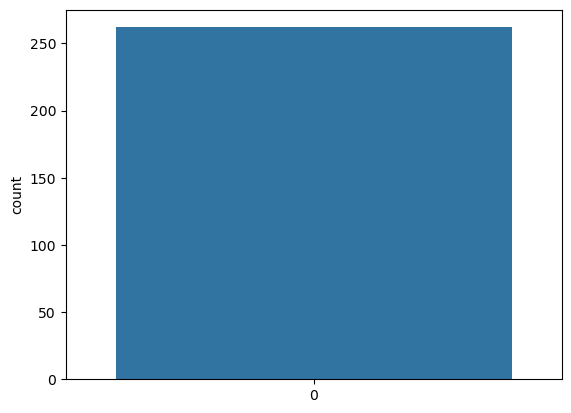

In [398]:
sns.countplot(train_y)
plt.show()

In [400]:
from imblearn.over_sampling import BorderlineSMOTE

# Create the BorderlineSMOTE object
sm = BorderlineSMOTE()

# Fit and transform the train dataset
X_train, y_train = sm.fit_resample(train_x, train_y)

AttributeError: 'NoneType' object has no attribute 'split'

In [353]:
# Class 불균형 문제 해결
train_x,train_y = BorderlineSMOTE(random_state=CFG.SEED).fit_resample(train_x,train_y)

AttributeError: 'NoneType' object has no attribute 'split'

In [354]:
train_x

,numGC,numA,numGC^2,sub,H,trait_class_1,SNP_01_class_1,SNP_02_class_1,SNP_03_class_1,SNP_04_class_1,...,6_BOVINE_class_3,6_HAPMAP_class_3,7_BTB_class_3,8_ARS_class_3,chrom_9_class_3,9_HAPMAP_class_3,9_BTB_class_3,10_BOVINE_class_3,SNP_total_class_3,concat_class_3
0,-0.986104,0.986104,-0.980678,-0.986104,-0.986104,0.589872,0.629825,0.596277,0.198659,0.568459,...,0.052672,0.001606,0.021469,0.136736,0.007118,0.010441,0.004969,0.039476,0.263359,0.263359
1,-1.270327,1.270327,-1.179312,-1.270327,-1.270327,0.589872,0.353265,0.596277,0.639087,0.400290,...,0.107779,0.001606,0.496570,0.003135,0.191962,0.060433,0.571236,0.039476,0.263359,0.263359
2,-0.417657,0.417657,-0.520685,-0.417657,-0.417657,0.589872,0.629825,0.343441,0.198659,0.568459,...,0.043893,0.001606,0.496570,0.003135,0.007118,0.010441,0.004969,0.039476,0.263359,0.263359
3,1.287685,-1.287685,1.361107,1.287685,1.287685,0.006216,0.008532,0.343441,0.198659,0.568459,...,0.934842,0.985834,0.496570,0.669802,0.726336,0.558720,0.571236,0.790417,0.754453,0.754453
4,-0.417657,0.417657,-0.520685,-0.417657,-0.417657,0.589872,0.629825,0.343441,0.641533,0.400290,...,0.043893,0.001606,0.021469,0.003135,0.004788,0.010441,0.033993,0.210528,0.263359,0.263359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,-0.701880,0.701880,-0.761136,-0.701880,-0.701880,0.589872,0.353265,0.596277,0.198659,0.568459,...,0.014631,0.001606,0.021469,0.136736,0.020258,0.060433,0.004969,0.039476,0.263359,0.263359
258,-0.986104,0.986104,-0.980678,-0.986104,-0.986104,0.589872,0.629825,0.335088,0.639087,0.400290,...,0.107779,0.372722,0.496570,0.136736,0.004788,0.010441,0.033993,0.210528,0.263359,0.263359
259,1.287685,-1.287685,1.361107,1.287685,1.287685,0.006216,0.353265,0.343441,0.198659,0.568459,...,0.107779,0.985834,0.733258,0.669802,0.967972,0.967972,0.571236,0.790417,0.263359,0.263359
260,0.719237,-0.719237,0.650208,0.719237,0.719237,0.006216,0.008532,0.343441,0.198659,0.568459,...,0.934842,0.985834,0.496570,0.136736,0.891460,0.803335,0.571236,0.790417,0.263359,0.263359


In [355]:
train_y

,0
0,1
1,2
2,1
3,0
4,2
...,...
257,1
258,2
259,0
260,0


In [341]:
# Class 불균형 문제 해결
# train_x,train_y = BorderlineSMOTE(random_state=CFG.SEED).fit_resample(train_x,train_y)

In [336]:
#Submission file 준비
submit = pd.read_csv('./sample_submission.csv')

In [337]:
#Model Selection -> 여러 모델링 실험결과 종류가 다른 모델 여러개를 앙상블 하는 것이 좋다 판단함
models = [
    ('bag', BaggingClassifier(random_state=CFG.SEED)),
    ('dt', DecisionTreeClassifier(random_state=CFG.SEED)),
    ('rc', RidgeClassifier(random_state=CFG.SEED)),
    ('xgb', XGBClassifier(random_state=CFG.SEED)),
    ('lgb', LGBMClassifier(random_state=CFG.SEED)),
    ('gb', GradientBoostingClassifier(random_state=CFG.SEED)),
    ('svc', SVC(random_state=CFG.SEED)),
    ('rcc', RidgeClassifierCV()),
    ('rf', RandomForestClassifier(random_state=CFG.SEED))
]

In [338]:
#최종모델은 Votingclassifier 사용하여 ensemble -> 제출결과 public score기준 XGBClassifier와 RandomForestClassifier 성능이 좋아 가중치를 주었음
best_model  = VotingClassifier(models, voting='hard', weights=[1,1,1,2,1,1,1,1,2])
best_model.fit(train_x,train_y)

VotingClassifier(estimators=[('bag', BaggingClassifier(random_state=26)),
                             ('dt', DecisionTreeClassifier(random_state=26)),
                             ('rc', RidgeClassifier(random_state=26)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_me...
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=26,
                                            reg_alpha=None, reg_lambda=None, ...)),
                             ('lgb', LGBMClassifier(random_state=26)),
                             ('gb',
                              GradientBoostingClassifier(random_state=26)),
                             ('svc', SVC(random_state=26)),
                             ('rcc', RidgeClassifierCV()),
                             ('rf', RandomForestClassifier(random_state=26))],
                 weights=[1, 1, 1, 2, 1, 1, 1, 1, 2])

In [339]:
#test predict
pred = class_le.inverse_transform(best_model.predict(test_x))
submit['class'] = pred

In [340]:
pred

array(['A', 'B', 'C', 'C', 'A', 'B', 'C', 'B', 'A', 'A', 'C', 'B', 'B',
       'A', 'B', 'B', 'A', 'B', 'B', 'C', 'B', 'B', 'B', 'A', 'B', 'B',
       'B', 'A', 'A', 'B', 'A', 'A', 'B', 'C', 'A', 'B', 'C', 'B', 'B',
       'C', 'A', 'B', 'C', 'B', 'B', 'B', 'B', 'C', 'B', 'C', 'A', 'B',
       'A', 'B', 'B', 'B', 'C', 'A', 'B', 'C', 'A', 'B', 'C', 'C', 'C',
       'A', 'B', 'A', 'A', 'B', 'B', 'B', 'A', 'A', 'C', 'B', 'C', 'B',
       'B', 'B', 'C', 'B', 'A', 'B', 'B', 'B', 'B', 'B', 'C', 'A', 'B',
       'B', 'C', 'B', 'B', 'C', 'A', 'B', 'A', 'C', 'A', 'B', 'B', 'B',
       'A', 'A', 'C', 'B', 'A', 'B', 'C', 'B', 'B', 'B', 'B', 'A', 'A',
       'B', 'B', 'C', 'A', 'B', 'B', 'C', 'C', 'B', 'C', 'B', 'A', 'B',
       'A', 'A', 'B', 'B', 'B', 'C', 'A', 'A', 'B', 'A', 'A', 'A', 'C',
       'B', 'B', 'B', 'A', 'B', 'C', 'A', 'A', 'B', 'A', 'B', 'B', 'A',
       'A', 'B', 'C', 'A', 'B', 'C', 'B', 'B', 'A', 'A', 'C', 'B', 'B',
       'A', 'B', 'C', 'C', 'B', 'B'], dtype=object)

In [342]:
submit

,id,class
0,TEST_000,A
1,TEST_001,B
2,TEST_002,C
3,TEST_003,C
4,TEST_004,A
...,...,...
170,TEST_170,B
171,TEST_171,C
172,TEST_172,C
173,TEST_173,B


In [343]:
submit.to_csv('./Fine_20.csv',index=False)